In [1]:
#if (!require("BiocManager", quietly = TRUE))
  #install.packages("BiocManager")
#BiocManager::install("DOSE")
library(clusterProfiler)
library(tidyverse)
library(forcats)
library(ggrepel)
library(enrichplot)
library(tibble)
library(ggupset)
library(ggridges)
library(gage)
library(DOSE)
library(pathview)
library(ggpubr)



clusterProfiler v4.10.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:stats’:

    filter


── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()   masks clusterProfiler::filter(), stats::filter()
✖ dplyr::lag()  

# Generate ranked list of ko_id's and LFC
numeric vector: fold change or other type of numerical variable
- here I sorted by differential expression, taking the sign from LFC and value of significance from adjusted pvalue.
- top: most upregulated genes
- middle: most insignificantly expressed genes
- bottom: most downregulated genes

named vector: every number has a name, the corresponding gene ID
sorted vector: number should be sorted in decreasing order
import your data from a csv file, the file should contains two columns, one for gene ID (no duplicated ID allowed) and another one for fold change.
### Over expression analysis uses only DE genes
### Gene set expression analysis uses all genes with DE values

In [2]:
read.data = function(df){
    df = read.csv(paste("../expression_analysis/de_res_files/",df,".csv",sep=''))
    colnames(df)[1] = 'ko_id'
    df = filter(df, padj<=0.05)
    # create a ranked gene list
    genes=df$log2FoldChange
    names(genes)=as.character(df$ko_id)
    geneList=sort(genes, decreasing=T)
    # geneList is a sorted list of genes with thier DE ranking and ko_id as list names
    print(max(geneList))
    geneList
    }

                       

In [3]:
#High vs Low Fe
HvL8.geneList = read.data('lfc8.HvL.kegg')
HvL6.geneList = read.data('lfc6.HvL.kegg')
HvL13.geneList = read.data('lfc13.HvL.kegg')
#Fe ammendment vs Low Fe
AvL4.geneList = read.data('lfc4.AvL.kegg')
AvL8.geneList = read.data('lfc8.AvL.kegg')
AvL6.geneList = read.data('lfc6.AvL.kegg')
AvL13.geneList = read.data('lfc13.AvL.kegg')
tail(AvL13.geneList)

[1] 3.113503
[1] 1.894618
[1] 4.018916
[1] 2.148399
[1] 4.716677
[1] 2.218254
[1] 4.057904


K00372     K01679     K03743     isip_3     K16752     K03839 
 -6.450682  -6.728829  -7.824595  -7.995611  -8.504650 -12.963369

# Pull our Kegg Metabolism and cell cycle pathways
This will only compare ko's to those which are annotated to metabolism and cell cycle pathways and not human diseases. 

In [4]:
kg.ko=kegg.gsets(species='ko', check.new=T) 
kegg.sigmet=kg.ko$kg.sets[kg.ko$sigmet.idx]
kegg.sigmet.term2gene = data.frame(
    TERM=str_remove(rep(names(kegg.sigmet), sapply(kegg.sigmet, length)), 'ko[[:digit:]]{5}'), 
    GENE= unlist(kegg.sigmet))

kegg.met = kg.ko$kg.sets[kg.ko$met.idx]
kegg.gs.term2gene = data.frame(
    TERM=str_remove(rep(names(kegg.met), sapply(kegg.met, length)), 'ko[[:digit:]]{5}'), 
    GENE= unlist(kegg.met))
head(kegg.gs.term2gene)

,TERM,GENE
,<chr>,<chr>
ko00010 Glycolysis / Gluconeogenesis1,Glycolysis / Gluconeogenesis,K00001
ko00010 Glycolysis / Gluconeogenesis2,Glycolysis / Gluconeogenesis,K00002
ko00010 Glycolysis / Gluconeogenesis3,Glycolysis / Gluconeogenesis,K00016
ko00010 Glycolysis / Gluconeogenesis4,Glycolysis / Gluconeogenesis,K00114
ko00010 Glycolysis / Gluconeogenesis5,Glycolysis / Gluconeogenesis,K00121
ko00010 Glycolysis / Gluconeogenesis6,Glycolysis / Gluconeogenesis,K00128


In [ ]:
a=kegg.met[1]
a=data.frame(ko_id=unlist(a))
#a= a %>% rownames_to_column('Path_name') 
head(a)
#a$pat=str_split(a$Path_name, 'ko[[:digit:]]*', simplify = T)
b = str_split_fixed(rownames(a), ' ',n = 2)
b = as_tibble(b, .name_repair = make.names)
colnames(b) = c('path_code','path_name')
c=bind_cols(ko_id=a$ko_id, b)
head(c)


# Run GSE analysis 

In [5]:
run.gsea = function(geneList){
    gsea = GSEA(geneList, minGSSize=5, eps = 0,
                pvalueCutoff = 0.05, 
                pAdjustMethod = 'fdr',
                TERM2GENE = kegg.gs.term2gene)
    gsea    
}              

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.78% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (1.26% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“There were 3 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimp

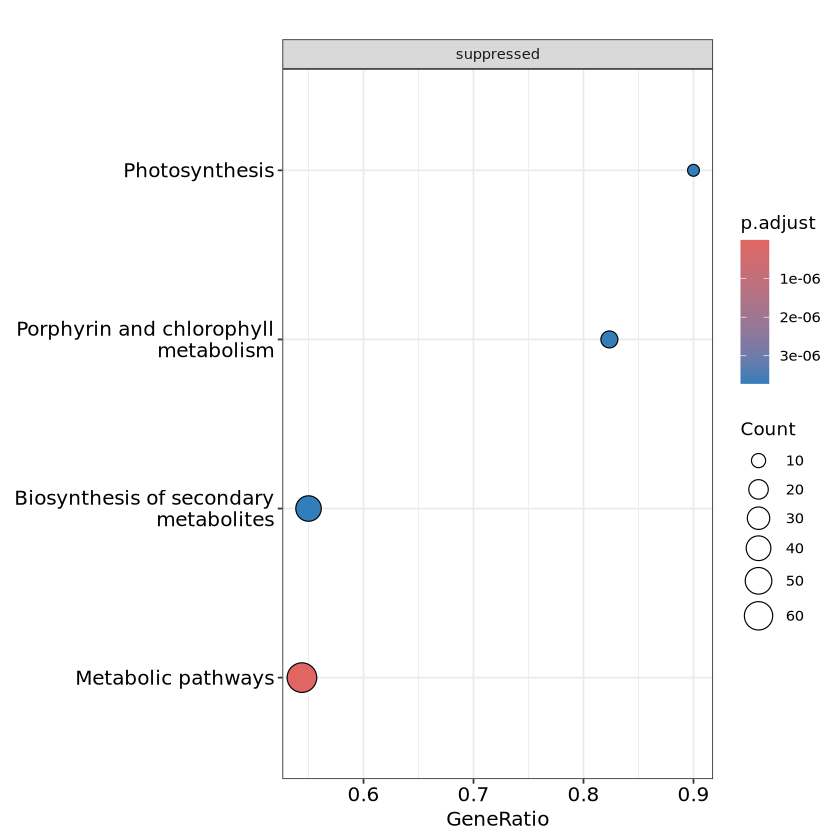

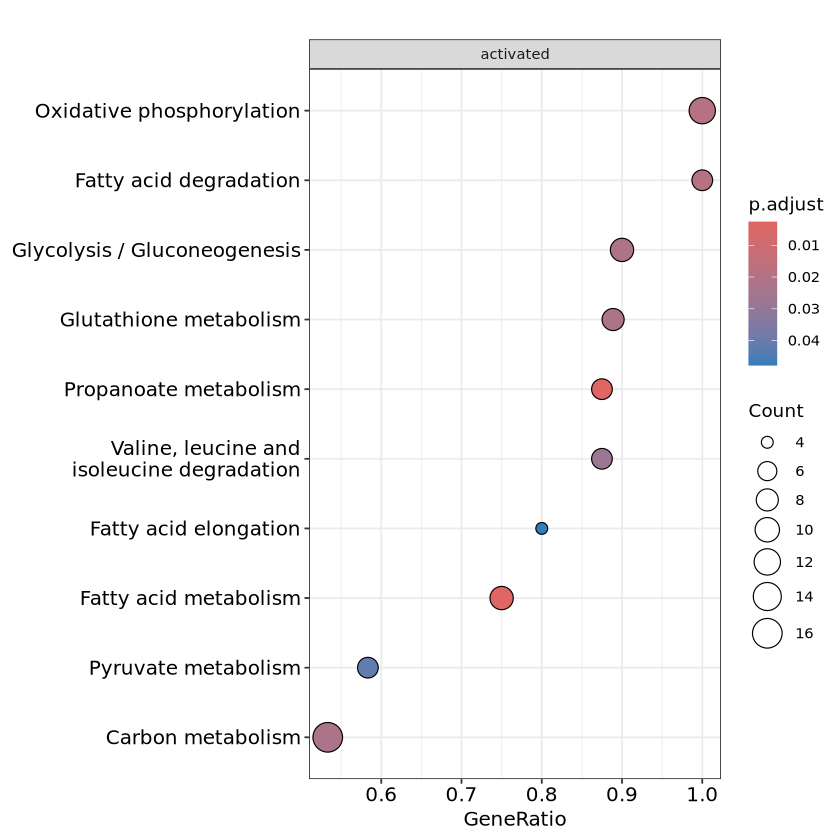

In [10]:
gsea.HvL8=run.gsea(HvL8.geneList)
gsea.AvL8=run.gsea(AvL8.geneList)

dotplot(gsea.HvL8, showCategory=100,split=".sign") + 
                    facet_grid(.~.sign)
dotplot(gsea.AvL8, showCategory=100,split=".sign") + 
                    facet_grid(.~.sign)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (8.34% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (8.36% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ERROR: Error in `$<-.data.frame`(`*tmp*`, ".sign", value = "activated"): replacement has 1 row, data has 0


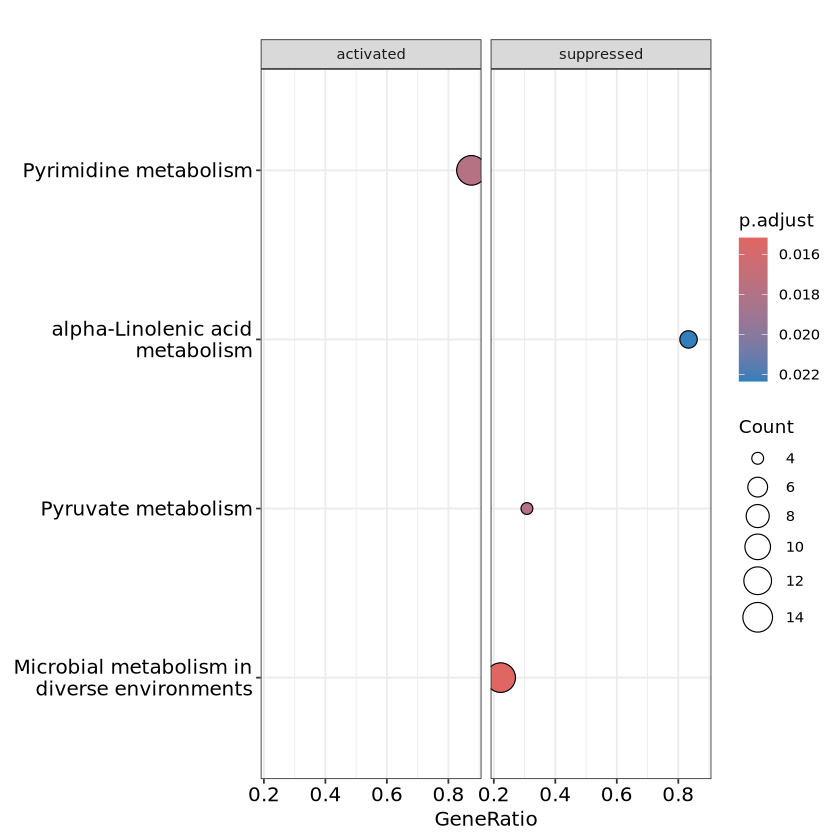

In [6]:
gsea.HvL6=run.gsea(HvL6.geneList)
gsea.AvL6=run.gsea(AvL6.geneList)
dotplot(gsea.HvL6, showCategory=30,split=".sign") + 
                    facet_grid(.~.sign)
dotplot(gsea.AvL6, showCategory=30,split=".sign") + 
                    facet_grid(.~.sign)

preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...



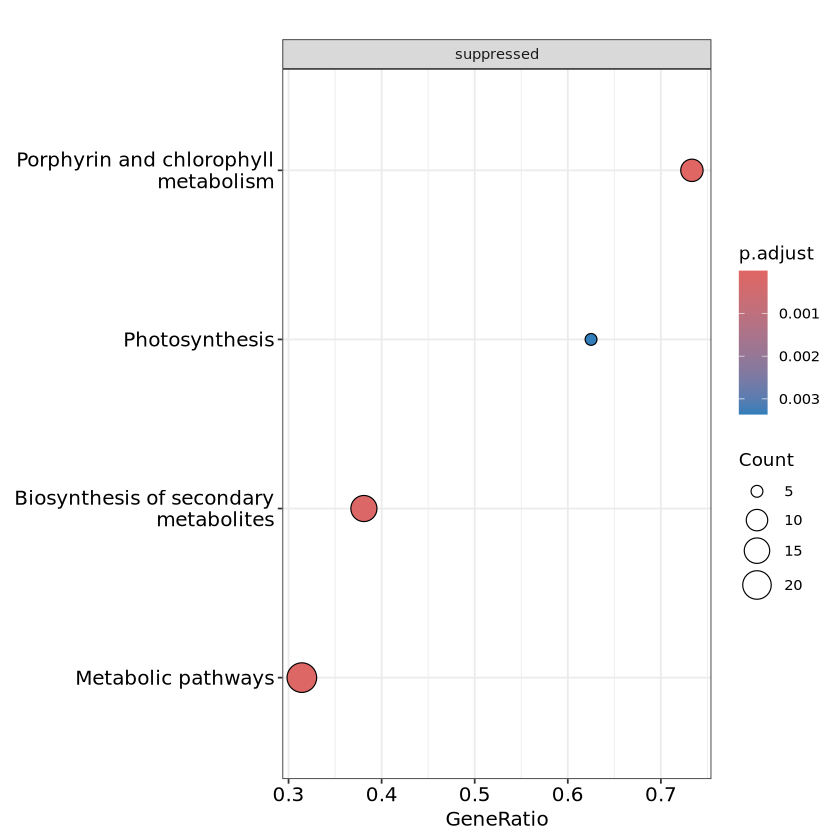

In [7]:

gsea.AvL4=run.gsea(AvL4.geneList)
dotplot(gsea.AvL4, showCategory=30,split=".sign") + 
                    facet_grid(.~.sign)


preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (7.24% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (6.54% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ERROR: Error in `$<-.data.frame`(`*tmp*`, ".sign", value = "activated"): replacement has 1 row, data has 0


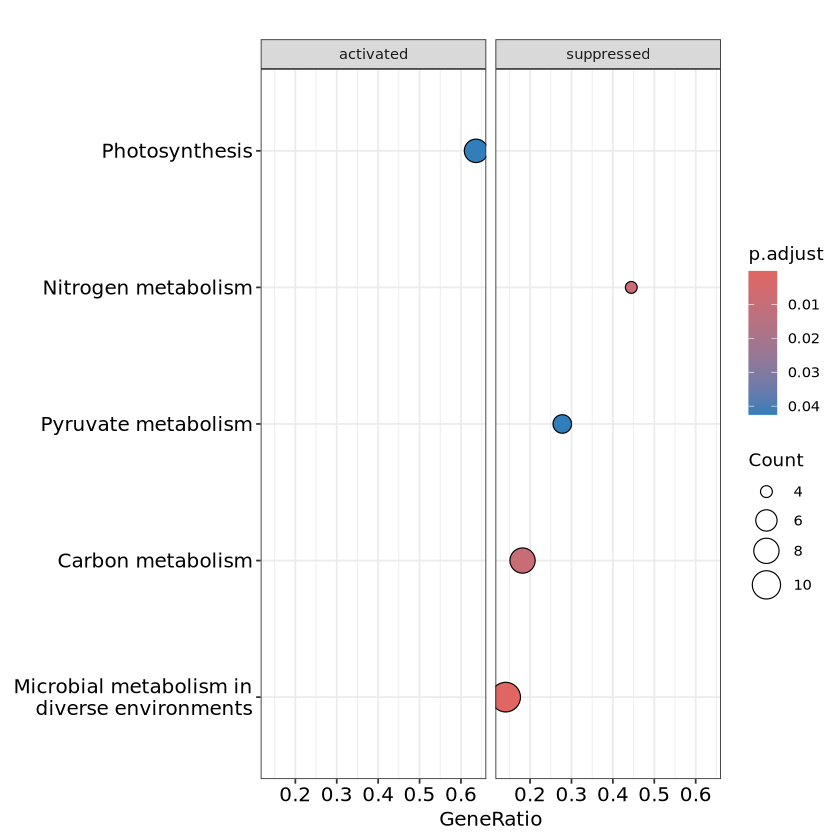

In [8]:
gsea.HvL13=run.gsea(HvL13.geneList)
gsea.AvL13=run.gsea(AvL13.geneList)

dotplot(gsea.HvL13, showCategory=30,split=".sign") + 
                    facet_grid(.~.sign)
dotplot(gsea.AvL13, showCategory=30,split=".sign") + 
                    facet_grid(.~.sign)

## Pull out result DF and add organism name
Create a df for each comparison 

In [11]:
Avl8=mutate(gsea.AvL8@result, organism='C. closterium UGA8')
Avl4=mutate(gsea.AvL4@result, organism='C. closterium UGA4')
Avl6=mutate(gsea.AvL6@result, organism='G. oceanica')
Avl13=mutate(gsea.AvL13@result, organism='G. huxleyi')


Hvl8=mutate(gsea.HvL8@result, organism='C. closterium UGA8')
Hvl6=mutate(gsea.HvL6@result, organism='G. oceanica')
Hvl13=mutate(gsea.HvL13@result, organism='G. huxleyi')

Hvl = bind_rows(Hvl13,Hvl8,Hvl6)
Avl = bind_rows(Avl4, Avl13, Avl8, Avl6)


## Plot enrichments

## Make dot plots
First, make treatment column and filter enrichment by positive/negative NES
Make dotplot with organisms on X and Description on Y. 

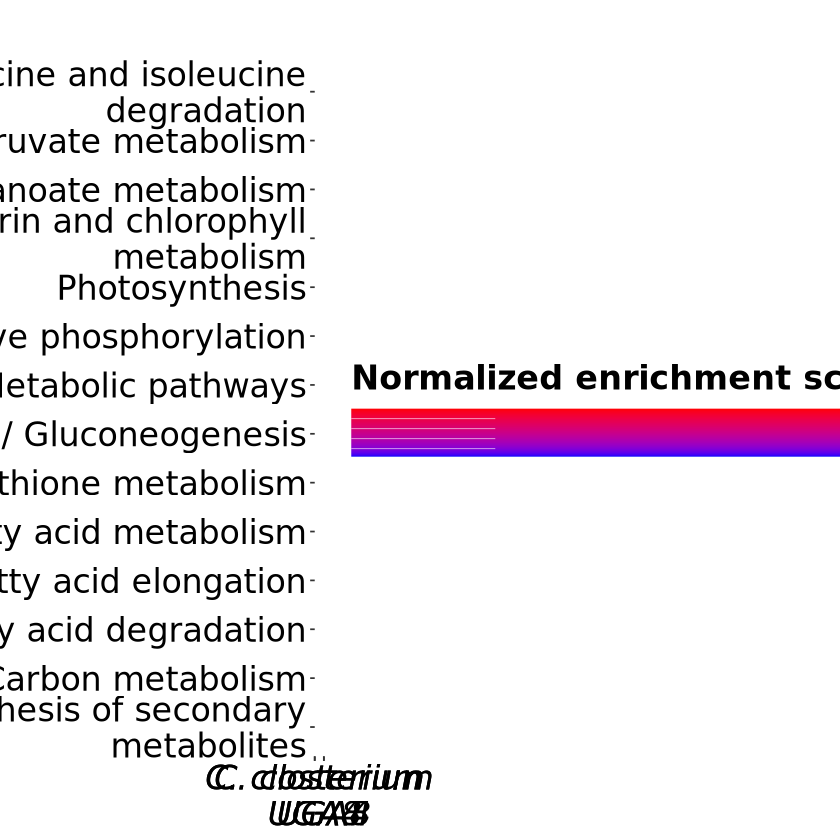

In [12]:
Hvl$treatment = ifelse(Hvl$NES > 0, 'High Iron','Low Iron')
Avl$treatment = ifelse(Avl$NES > 0, 'Iron Amendment', 'Low Iron')

all.gsea.dotplot = function(df){
    ggplot(df, aes(organism, Description, color=p.adjust, size=abs(NES)))+ 
   geom_point(stat = 'identity', size=20)+
facet_grid(~treatment, scales='free_y')+
theme_bw()+
xlab(NULL) + 
ylab(element_blank()) +
scale_y_discrete(labels=function(x) str_wrap(x, 35))+ #, expand=c(0.02,0.02)) +
scale_x_discrete(labels=function(x) str_wrap(x, 15)) +
scale_color_gradient(low = 'red', high='blue')+
guides(color=guide_colorbar(title = 'Normalized enrichment score', reverse=TRUE, 
                            title.theme = element_text(size=20, face='bold'),
                           title.position='top', label.theme=element_text(size=20),
                           barwidth=30, barheight=2)) +
theme(text = element_text(color='black', size=20), 
          panel.grid.minor = element_line(colour = 'grey'), 
          strip.text=element_text(size=25, face='bold'), 
          strip.background=element_rect(fill='white'), 
          axis.text.y=element_text(size=20, color='black'), 
          axis.text.x = element_text(size=20, face = 'italic', color='black'),
    plot.margin=margin(0.2,0.2,0.2,3, unit='cm'))
}

#png(file = '../figs/gsea_dotplot_HvL.png',width = 10, height = 15)
hvl.gsea.dotplot = all.gsea.dotplot(Hvl)    
#print(hvl.gsea.dotplot)
#dev.off()
#ggsave(filename = '../figs/gsea_dotplot_HvL.png', hvl.gsea.dotplot, device='png', height = 10, width=15)
                 
#png(file = '../figs/gsea_dotplot_AvL.png',width = 10, height = 15)
avl.gsea.dotplot = all.gsea.dotplot(Avl) 
#print(avl.gsea.dotplot)
#dev.off()
#ggsave(filename = '../figs/gsea_dotplot_AvL.png', avl.gsea.dotplot, device='png', height = 5, width=8)
                 
                 
avl.gsea.dotplot

In [13]:
                                  
#gsea_dotplot_all= ggarrange(avl.gsea.dotplot, hvl.gsea.dotplot, ncol=1, common.legend=T, align='v', legend='right')      
                 
#ggsave(filename = '../figs/gsea_dotplot_all.png', gsea_dotplot_all, device='png', height = 25, width=19)

gsea_dotplot_all= ggarrange(avl.gsea.dotplot, hvl.gsea.dotplot, ncol=1, common.legend=T, font.label = element_text(size=30, face='bold'),
                            align='v', legend='bottom',labels = c('A','B'))  
                 
ggsave(filename = '../figures/Fig5_gsea.png', gsea_dotplot_all, device='png', height = 25, width=23)

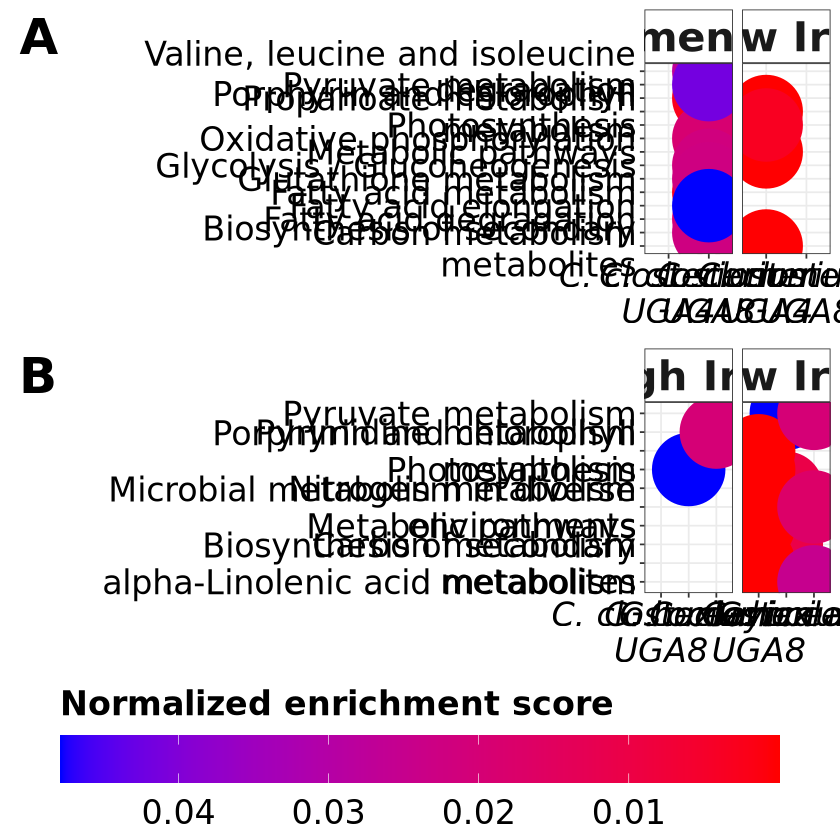

In [14]:
gsea_dotplot_all

# Make table of enrichment and genes within pathways.

In [16]:
colnames(Hvl)
split_into_multiple <- function(column, pattern = "/", into_prefix){
    #adapted from post on stack overflow
    cols <- str_split_fixed(column, pattern, n = Inf)
  # Replace empty matrix indicies with NA's 
    cols[which(cols == "")] <- NA
  # turn matrix into a table with unique but arbitraty column names  
    cols <- as_tibble(cols, .name_repair = make.names)
  # where m = # columns in tibble 'cols'
    m <- dim(cols)[2]
  # assign column names as 'into_prefix_1', 'into_prefix_2', ..., 'into_prefix_m' 
    names(cols) <- paste(into_prefix, 1:m, sep = "_")
    print('# of values in matrix w/o NA:')
    print(sum(!is.na(cols)))
    return(cols)
}

clean_ko <- function(df){
    ko_iterations <- split_into_multiple(df$core_enrichment, "/", "ko:")
    df = df %>% select(c('Description','organism','treatment','NES')) %>% bind_cols(ko_iterations)
    df_clean = pivot_longer(df, cols = !c('Description','organism','treatment','NES'), 
                            values_drop_na = T,
                            values_to = 'ko_id', names_to = 'ko_count')
    df_clean=df_clean %>% select(!'ko_count')
    df_clean
    }

core.ko.Hvl=clean_ko(Hvl)
core.ko.Avl=clean_ko(Avl)
head(core.ko.Avl)

[1] "ID"              "Description"     "setSize"         "enrichmentScore"
 [5] "NES"             "pvalue"          "p.adjust"        "qvalue"         
 [9] "rank"            "leading_edge"    "core_enrichment" "organism"       
[13] "treatment"

[1] "# of values in matrix w/o NA:"
[1] 207
[1] "# of values in matrix w/o NA:"
[1] 140


Description,organism,treatment,NES,ko_id
<chr>,<chr>,<chr>,<dbl>,<chr>
Porphyrin and chlorophyll metabolism,C. closterium UGA4,Low Iron,-2.427292,K02492
Porphyrin and chlorophyll metabolism,C. closterium UGA4,Low Iron,-2.427292,K03403
Porphyrin and chlorophyll metabolism,C. closterium UGA4,Low Iron,-2.427292,K04040
Porphyrin and chlorophyll metabolism,C. closterium UGA4,Low Iron,-2.427292,K01599
Porphyrin and chlorophyll metabolism,C. closterium UGA4,Low Iron,-2.427292,K00231
Porphyrin and chlorophyll metabolism,C. closterium UGA4,Low Iron,-2.427292,K03428


In [18]:
ko.def=read.csv('../expression_analysis/kegg_files/ko_def.csv')
ko.def$name=str_remove(ko.def$name, '\\[EC:.+')

core.ko.Hvl = right_join(ko.def, core.ko.Hvl, by='ko_id')
core.ko.Avl = right_join(ko.def, core.ko.Avl, by='ko_id')


In [19]:
write.csv(core.ko.Hvl,'./de_res_files/core.ko.Hvl.csv',  row.names=F)
write.csv(core.ko.Avl,'./de_res_files/core.ko.Avl.csv',  row.names=F)

Warning message in file(file, ifelse(append, "a", "w")):
“cannot open file './de_res_files/core.ko.Hvl.csv': No such file or directory”


ERROR: Error in file(file, ifelse(append, "a", "w")): cannot open the connection
